# Autoregressive Model Testing (SARIMA & SARIMAX)

In [486]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML

In [487]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Data Preparation

In [488]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC', 'CC Monthly % Change', 'VIX', 'MOVE']
vol_macro_list = ['vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin', 'Bitcoin Price']
pc_list = ['PC1_macro', 'PC2_macro']
train_end = '2024-01-01'

In [489]:
ar_orders = {}
ar_orders['LFPR'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag': 1}
ar_orders['CPI'] = {'p': 1, 'd': 2,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag': 0}
ar_orders['r'] = {'p': 1, 'd': 2,'q': 0, 'P': 1, 'D': 0, 'Q': 0, 'lag': 0}
ar_orders['M1'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 0, 'Q': 1, 'lag': 1}
ar_orders['GDP Monthly'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag':0}
ar_orders['IM'] = {'p': 1, 'd': 1,'q': 1, 'P': 2, 'D': 1, 'Q': 0, 'lag':0}
ar_orders['EX'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag':1}
ar_orders['CC'] = {'p': 2, 'd': 1,'q': 0, 'P': 1, 'D': 1, 'Q': 1, 'lag':0}
ar_orders['CC Monthly % Change'] = {'p': 2, 'd': 0,'q': 0, 'P': 2, 'D': 1, 'Q': 0, 'lag':3}
ar_orders['VIX'] = {'p': 1, 'd': 0,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag':0}
ar_orders['MOVE'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 0, 'Q': 0, 'lag':6}

ar_orders['PC1_macro'] = {'p': 1, 'd': 1,'q': 1, 'P': 1, 'D': 1, 'Q': 0, 'lag':2}
ar_orders['PC2_macro'] = {'p': 1, 'd': 1,'q': 1, 'P': 1, 'D': 1, 'Q': 0, 'lag':0}

ar_orders['vol_LFPR'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['vol_CPI'] = {'p': 1, 'd': 1, 'q': 0}
ar_orders['vol_r'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['vol_M1'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['vol_GDP'] = {'p': 1, 'd': 1, 'q': 0}
ar_orders['vol_IM'] = {'p': 1, 'd': 2,'q': 0}
ar_orders['vol_EX'] = {'p': 1, 'd': 1, 'q': 0}
ar_orders['vol_CC'] = {'p': 1, 'd': 1,'q': 0}

## Checking Variable Stationarity, ACF, PACF

In [490]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")
    return p_value

In [491]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=30, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

ADF test for PC2_macro: p-value = 0.7538


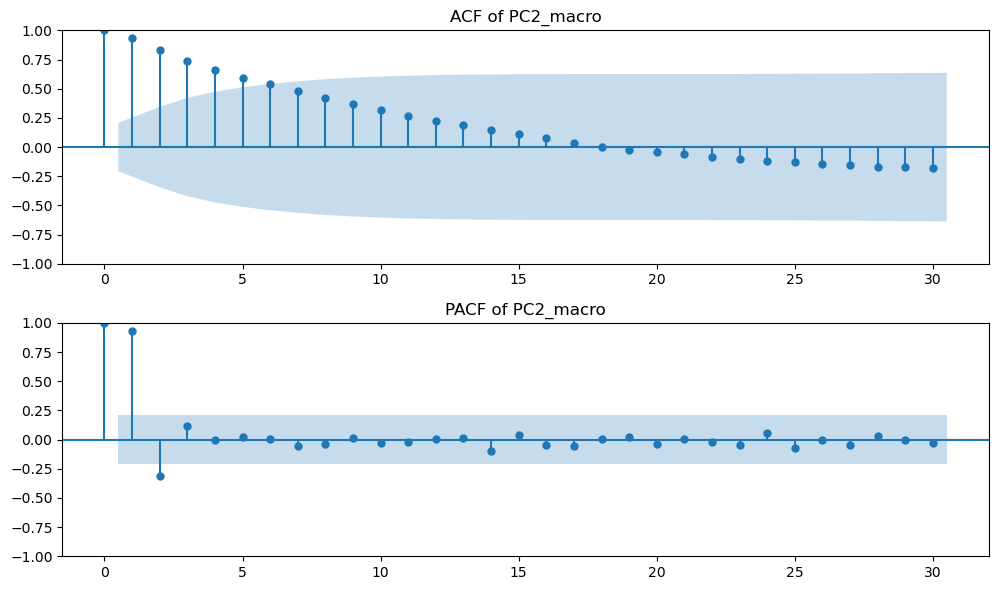

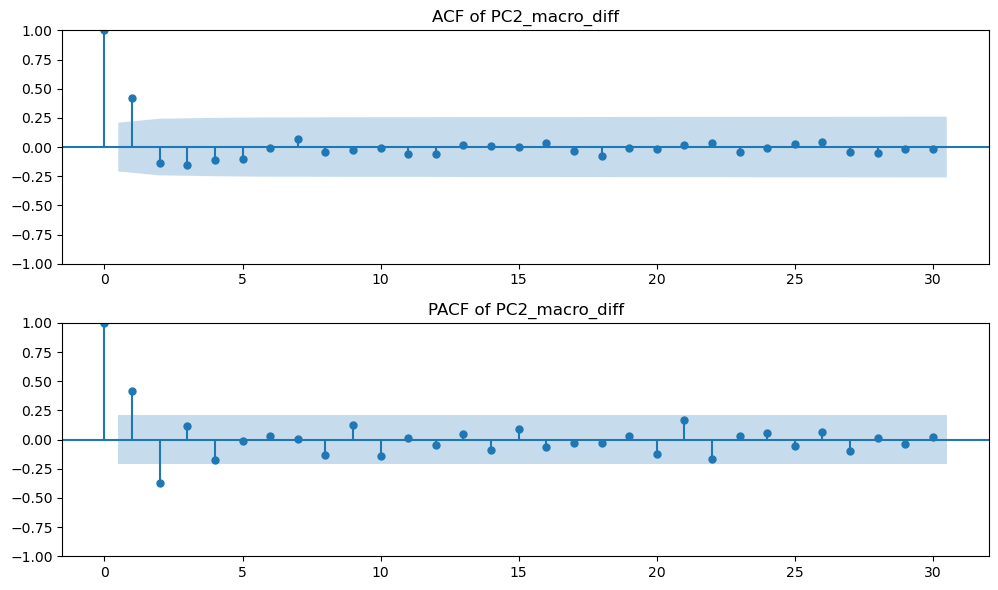

ADF test for PC2_macro_diff: p-value = 0.0000


1.2891921095548633e-10

In [492]:
variable = 'PC2_macro'
check_stationarity(df[variable])
series = df[variable].dropna()
acf(series, variable)
df[f'{variable}_diff'] = df[variable].diff()
series = df[f'{variable}_diff'].dropna()
acf(series, f'{variable}_diff')
check_stationarity(df[f'{variable}_diff'])

# df[f'{variable}_diff_diff'] = df[f'{variable}_diff'].diff()
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

## SARIMA(X) Model

In [493]:
def run_model(df, macro, asset, plot):
    df_temp = df[[macro, asset]].dropna().copy()
    order_dict = ar_orders.get(macro, {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D':1, 'Q':0, 'lag': 0})  # Default to AR(1) if macro not found

    p = order_dict['p']
    d = order_dict['d']
    q = order_dict['q']
    P = order_dict['P']
    D = order_dict['D']
    Q = order_dict['Q']
    asset_lag = order_dict['lag']

    # Asset lag
    for lag in range(1, asset_lag + 1):
        df_temp[f'{asset}_lag{lag}'] = df_temp[asset].shift(lag)
    exog_cols = [asset] + [f'{asset}_lag{lag}' for lag in range(1, asset_lag + 1)]

    exog = df_temp[exog_cols].dropna()
    target = df_temp.loc[exog.index, macro]

    # Train/test split
    train_endog = target[:train_end]
    train_exog = exog[:train_end]
    test_endog = target[train_end:]
    test_exog = exog[train_end:]

    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        ar_model = SARIMAX(train_endog, order=(p, d, q), seasonal_order = (P, D, Q, 12))
        ar_result = ar_model.fit(disp=False)
        arx_model = SARIMAX(train_endog, exog = train_exog, order=(p, d, q), seasonal_order = (P, D, Q, 12))
        arx_result = arx_model.fit(disp=False)
        # Check for convergence warnings
        for warning in w:
            if issubclass(warning.category, ConvergenceWarning):
                print(f"[WARNING] Convergence issue in macro: {macro}, asset: {asset}")

    # AR model
    forecast_ar = ar_result.get_forecast(steps=len(test_endog))
    pred_ar = forecast_ar.predicted_mean
    conf_int_ar = forecast_ar.conf_int() 

    # ARX model
    forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
    pred_arx = forecast_arx.predicted_mean
    conf_int_arx = forecast_arx.conf_int()

    pred_ar.index = test_endog.index
    pred_arx.index = test_endog.index
    conf_int_ar.index = test_endog.index
    conf_int_arx.index = test_endog.index

    # print(ar_result.summary())
    # print(arx_result.summary())

    if plot == True:
        plt.figure(figsize=(10, 5))
        plt.plot(target, label='Actual ' + macro, color = 'black')
        plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', color = 'blue')
        plt.fill_between(
            pred_ar.index,
            conf_int_ar.iloc[:, 0],  # Lower bound
            conf_int_ar.iloc[:, 1],   # Upper bound
            color='blue',
            alpha=0.1,
            label='AR 95% CI'
        )
        plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', color = 'red')
        plt.fill_between(
            pred_arx.index,
            conf_int_arx.iloc[:, 0],  # Lower bound
            conf_int_arx.iloc[:, 1],  # Upper bound
            color='red',
            alpha=0.1,
            label='ARX 95% CI'
        )
        plt.title("Out-of-Sample Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot only test data with forecasts
        plt.figure(figsize=(10, 5))
        plt.plot(test_endog, label='Actual ' + macro, marker='o', color = 'black')
        plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', marker='x', color = 'blue')
        plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', marker='s', color = 'red')
        plt.title("Forecast vs Actual (Test Period Only)")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Metrics
    metrics = [
        {
            'Model': 'AR',
            'MAE': mean_absolute_error(test_endog, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_ar)),
            'R2': r2_score(test_endog, pred_ar),
            'MAPE (%)': mean_absolute_percentage_error(test_endog, pred_ar) * 100,
            'Order': f'({p},{d},{q})'
        },
        {
            'Model': 'ARX',
            'MAE': mean_absolute_error(test_endog, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_arx)),
            'R2': r2_score(test_endog, pred_arx),
            'MAPE (%)': mean_absolute_percentage_error(test_endog, pred_arx) * 100,
            'Order': f'({p},{d},{q})'
        }
    ]
    df_metrics = pd.DataFrame(metrics).set_index('Model')

    # Display the table
    # print(f"\nModel Performance Comparison for Macro: {macro}, Asset: {asset}")
    # print(df_metrics[['MAE', 'RMSE', 'R2', 'MAPE']])
    
    return df_metrics 

## All Macro & Crypto Combination

In [494]:
results_list = []
asset = 'Bitcoin'
for macro in macro_list:
        # Run model, plot=False to skip plotting in batch run
        metrics_df = run_model(df.copy(), macro, asset, asset_lag=0, plot=False)
        
        # metrics_df is a DataFrame with index Model (AR, ARX) and columns MAE, RMSE, R2, MAPE, Order
        # Add macro and asset columns for clarity
        metrics_df['Macro'] = macro
        metrics_df['Asset'] = asset
        
        results_list.append(metrics_df.reset_index())
# Combine all results into one DataFrame
final_results = pd.concat(results_list, ignore_index=True)

# Rearrange columns to show Model, Macro, Asset, and errors only
final_results = final_results[['Model', 'Macro', 'Asset', 'MAE', 'RMSE', 'R2', 'MAPE (%)']]

# Format float columns for better readability
float_cols = ['MAE', 'RMSE', 'R2']
final_results[float_cols] = final_results[float_cols]

TypeError: run_model() got an unexpected keyword argument 'asset_lag'

### Combinations Where Adding Asset Data Improves the Model

In [ ]:
# Reshape for comparison
df_wide = final_results.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2', 'MAPE (%)']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_MAPE'] = df_wide['MAPE (%)_ARX'] < df_wide['MAPE (%)_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_MAPE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics (MAE, RMSE, MAPE, R²):")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'MAPE (%)_AR', 'MAPE (%)_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")


# Partial wins
print("\n Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX']])

print("\n Combinations where ARX has lower RMSE:")
display(df_wide[df_wide['ARX_better_RMSE']][['Macro', 'Asset', 'RMSE_AR', 'RMSE_ARX']])

print("\n Combinations where ARX has lower MAPE:")
display(df_wide[df_wide['ARX_better_MAPE']][['Macro', 'Asset', 'MAPE (%)_AR', 'MAPE (%)_ARX']])

print("\n Combinations where ARX has higher R²:")
display(df_wide[df_wide['ARX_better_R2']][['Macro', 'Asset', 'R2_AR', 'R2_ARX']])

Combinations where ARX (with asset) outperforms AR on all metrics (MAE, RMSE, MAPE, R²):


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,MAPE (%)_AR,MAPE (%)_ARX,R2_AR,R2_ARX
1,CC Monthly % Change,Bitcoin,0.040971,0.032487,0.044379,0.038860,206.036895,169.907644,-0.018412,0.219131
4,GDP Monthly,Bitcoin,119.339310,68.426025,126.999847,79.782723,0.511925,0.293271,0.567334,0.829249
5,IM,Bitcoin,87.586681,86.187319,134.411491,119.557925,2.117006,2.084138,0.135274,0.315833
7,M1,Bitcoin,374.377375,196.161460,455.854931,232.347026,2.052576,1.081379,-4.670213,-0.473060
8,MOVE,Bitcoin,13.073672,11.641730,14.956724,14.402779,13.216341,11.435605,-0.582746,-0.467678



 Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX
0,CC,Bitcoin,2.526753,2.517942
1,CC Monthly % Change,Bitcoin,0.040971,0.032487
4,GDP Monthly,Bitcoin,119.339310,68.426025
5,IM,Bitcoin,87.586681,86.187319
7,M1,Bitcoin,374.377375,196.161460
8,MOVE,Bitcoin,13.073672,11.641730



 Combinations where ARX has lower RMSE:


,Macro,Asset,RMSE_AR,RMSE_ARX
1,CC Monthly % Change,Bitcoin,0.044379,0.038860
4,GDP Monthly,Bitcoin,126.999847,79.782723
5,IM,Bitcoin,134.411491,119.557925
7,M1,Bitcoin,455.854931,232.347026
8,MOVE,Bitcoin,14.956724,14.402779



 Combinations where ARX has lower MAPE:


,Macro,Asset,MAPE (%)_AR,MAPE (%)_ARX
0,CC,Bitcoin,3.396513,3.379866
1,CC Monthly % Change,Bitcoin,206.036895,169.907644
4,GDP Monthly,Bitcoin,0.511925,0.293271
5,IM,Bitcoin,2.117006,2.084138
7,M1,Bitcoin,2.052576,1.081379
8,MOVE,Bitcoin,13.216341,11.435605



 Combinations where ARX has higher R²:


,Macro,Asset,R2_AR,R2_ARX
1,CC Monthly % Change,Bitcoin,-0.018412,0.219131
4,GDP Monthly,Bitcoin,0.567334,0.829249
5,IM,Bitcoin,0.135274,0.315833
7,M1,Bitcoin,-4.670213,-0.473060
8,MOVE,Bitcoin,-0.582746,-0.467678


## Testing Individual Combinations

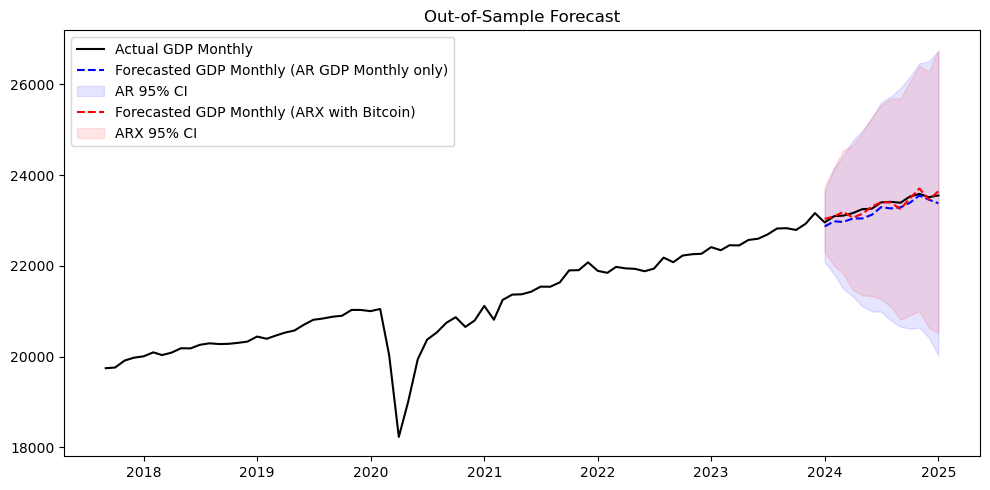

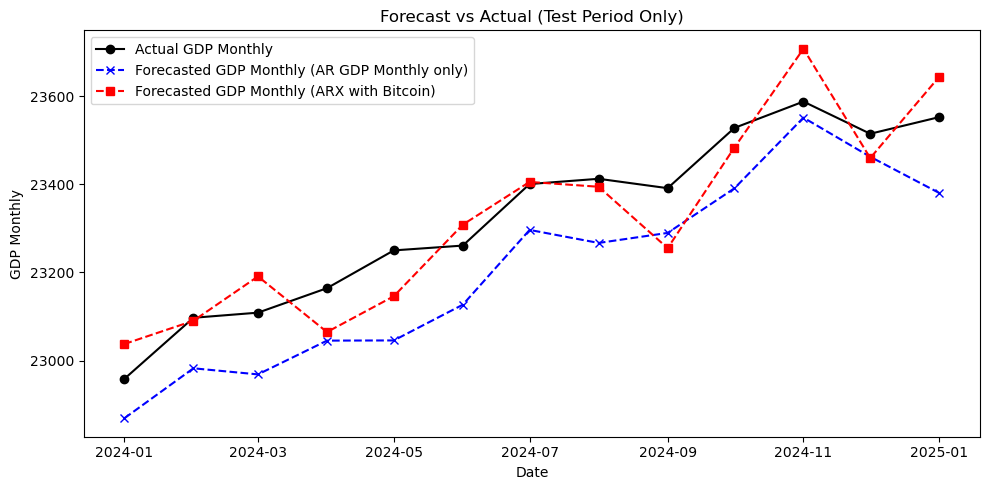

,MAE,RMSE,R2,MAPE (%),Order
Model,,,,,
AR,119.339310,126.999847,0.567334,0.511925,"(1,1,0)"
ARX,68.426025,79.782723,0.829249,0.293271,"(1,1,0)"


In [497]:
macro = 'GDP Monthly'
asset = 'Bitcoin'
run_model(df.copy(), macro, asset, plot=True)